## Load data


In [25]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import numpy as np
import seaborn as sns

idx = pd.IndexSlice

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [26]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['rep', 'fps', 'highquality', 'route_index'])
    return df


def make_df(path: str):
    with open(path, "r") as f:

        p = Path(path)

        x = p.stem.split("_")
        data = {}
        data['fps'] = int(x[1])
        data['highquality'] = x[3]

        rep_no = [x[-1] for x in path.split('/') if 'rep' in x][0]
        data['rep'] = int(rep_no)
        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [27]:
dfs = []
path = "data/ronin/rep*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

df = pd.concat(dfs).sort_index()
df = df[['driving_score', 'duration_system']]

## FILTER DATA


### Filter duplicated scenarios

Filter scenarios that are exactly the same


In [28]:
# Routes of theese scenarios are duplicated
excluded_routes = [20, 21, 22, 23]
df = df.drop(excluded_routes, level='route_index', axis=0)

### Filter 16 FPS

Carla crashes at 16 so we need to filter this results out


In [29]:
# filter out 16 fps
df = df.drop(16, level='fps', axis=0)

In [30]:
df

driving_score  duration_system
rep fps highquality route_index                                
0   10  False       0                 0.026306       642.428658
                    1                 0.232490       536.358014
                    2                 0.113361       489.848481
                    3                 0.432466       277.129590
                    4                 0.168521       404.950006
...                                        ...              ...
9   20  True        127               1.000000       287.689000
                    128               1.000000       397.439014
                    129               1.000000       234.884112
                    130               0.600000       373.658720
                    131               0.965542       459.435260

[17920 rows x 2 columns]

## PROCESS DATA


### Square error

RMSE


In [31]:
oracle_df = df.xs((20, "True"), level=[
    'fps', 'highquality'], drop_level=False).sort_index()
oracle_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1280 entries, (0, 20, 'True', 0) to (9, 20, 'True', 131)
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    1280 non-null   float64
 1   duration_system  1280 non-null   float64
dtypes: float64(2)
memory usage: 32.4+ KB


In [32]:

# oracle driving score per scenario
oracle_vec = oracle_df.groupby('route_index')['driving_score'].mean()
df['driving_score_error'] = (df['driving_score'] - oracle_vec).abs()

# df

## Plot distribution


In [33]:
data = df.xs("True", level='highquality', drop_level=False)
data = data.groupby(['highquality', 'fps', 'route_index'])[
    'driving_score_error'].mean().to_frame()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 896 entries, ('True', 10, 0) to ('True', 20, 131)
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   driving_score_error  896 non-null    float64
dtypes: float64(1)
memory usage: 11.7+ KB


<Axes: xlabel='fps', ylabel='driving_score_error'>

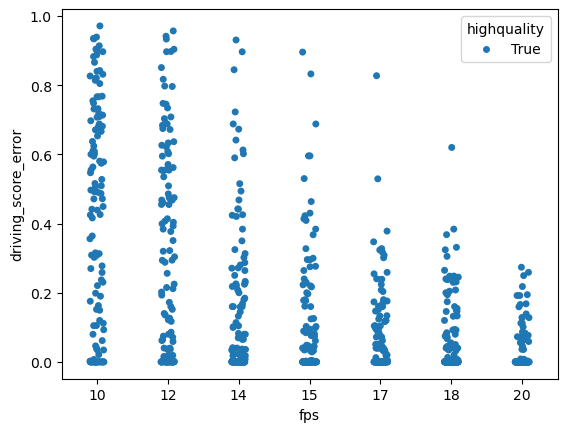

In [34]:
sns.stripplot(data, x='fps', y='driving_score_error',
              hue='highquality', dodge=True,)

^ why is that explanation on paper


### Important conclusions

There is some set of scenarios that is safe for each fidelity


## Clustering


Clusering for: fps = 10
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Clusering for: fps = 12
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Clusering for: fps = 14
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 4 4]
Clusering for: fps = 15
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

<Axes: xlabel='fps', ylabel='driving_score_error'>

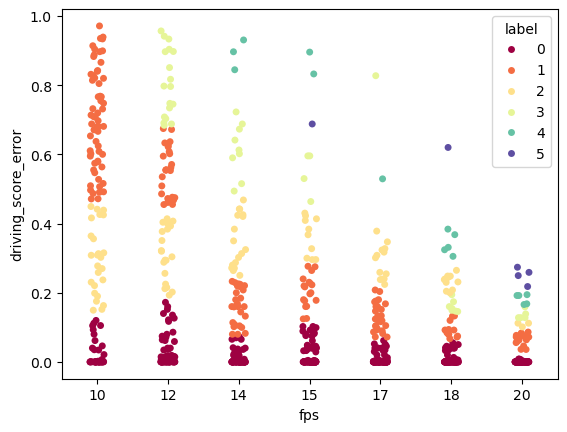

In [35]:
from sklearn.cluster import MeanShift

data = df.xs("True", level='highquality', drop_level=False)
data = data.groupby(['highquality', 'fps', 'route_index'])[
    'driving_score_error'].mean().to_frame()

n_clusters = 3
batched = []

for fps, batch in data.groupby('fps'):
    print(f'Clusering for: {fps = }')
    batch = batch.sort_values(by='driving_score_error')

    clustering = MeanShift().fit(batch)

    # batch.loc[:, 'label'] = np.sort(clustering.labels_)
    # batch.loc[:, 'label'] = batch.loc[:, 'label'].map(
    #     {0: "safe", 1: "moderate", 2: "risky"})

    batch.loc[:, 'label'] = clustering.labels_

    batched.append(batch)
    print(clustering.labels_)


data = pd.concat(batched)
sns.stripplot(data, x='fps', y='driving_score_error',
              hue='label', palette="Spectral")

### Conclusions

Clustering seems mess it up, or it's just me not knowing how to use it


## Distrubution check

Check if distribution for 10FPS and 12FPS is similar, mark 10FPS points and see where they fit on 12FPS distribution.
Repeat for epic/low rendering.


In [36]:
data = data.xs("True", level='highquality', drop_level=False)
data = data.groupby(['highquality', 'fps', 'route_index'])[
    'driving_score_error'].mean().to_frame()

In [37]:
fps10_ord = data.xs(10, level='fps', drop_level=True)
fps10_ord = fps10_ord.sort_values(by='driving_score_error')

fps10_ord = fps10_ord.reset_index()
fps10_ord['order'] = fps10_ord.index
fps10_ord = fps10_ord.set_index('route_index')
fps10_ord = fps10_ord['order'].sort_index()

data = data.join(fps10_ord)
data

driving_score_error  order
highquality fps route_index                            
True        10  0                   3.089193e-01     55
                1                   8.661724e-01    117
                2                   7.683216e-01    108
                3                   5.637767e-01     78
                4                   8.267248e-01    113
...                                          ...    ...
            20  127                 0.000000e+00    103
                128                 0.000000e+00     47
                129                 0.000000e+00     92
                130                 7.680000e-02     56
                131                 1.110223e-16     30

[896 rows x 2 columns]

<Axes: xlabel='fps', ylabel='driving_score_error'>

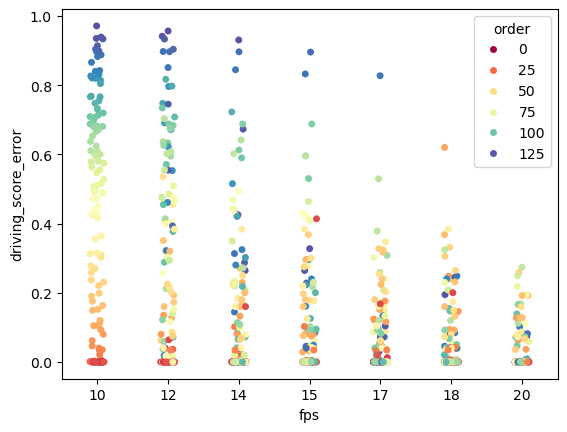

In [38]:
idx = pd.IndexSlice
data = data.loc[idx[:, :, :]]


sns.stripplot(data, x='fps', y='driving_score_error',

              hue='order', palette="Spectral")

## Scenario safety


<Axes: xlabel='fps', ylabel='driving_score_error'>

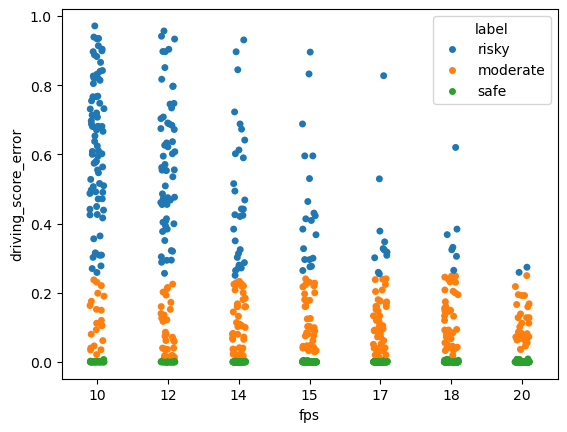

In [39]:
data = df.xs("True", level='highquality', drop_level=False)
data = data.groupby(['highquality', 'fps', 'route_index'])[
    'driving_score_error'].mean().to_frame()

safe_threshold = 0.01
risky_threshold = 0.25

data.loc[:, 'label'] = np.select(
    [data['driving_score_error'] < safe_threshold,
     data['driving_score_error'].between(safe_threshold, risky_threshold),
     data['driving_score_error'] > risky_threshold,
     ],
    ['safe', 'moderate', 'risky',],
)

sns.stripplot(data, x='fps', y='driving_score_error',
              hue='label',)

<Axes: xlabel='fps', ylabel='Count'>

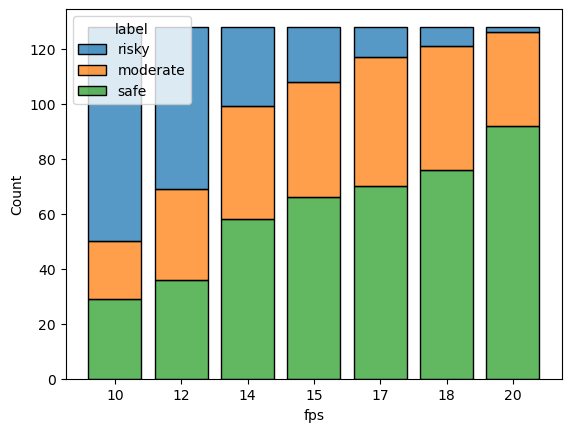

In [40]:

# treat fps as categorical value
d = data.reset_index()
d['fps'] = d['fps'].astype(str)

sns.histplot(
    d.reset_index(), x="fps", hue='label', multiple="stack",  shrink=.8,
)

In [45]:
data.xs(20, level='fps')['label'].value_counts()
36/128

0.28125

## Safe scenarios


### Indexes of safe scenarios


In [42]:
safe_mask = d['label'] == 'safe'
safe = d[safe_mask]

In [43]:

safe_routes = [set(routes['route_index'])
               for fps, routes in safe.groupby('fps')]
# safe_routes

In [44]:

# Intersection of all safe routes
safest = safe_routes[0].intersection(*safe_routes)
safest

{24,
 25,
 30,
 31,
 35,
 42,
 43,
 47,
 66,
 67,
 69,
 71,
 85,
 86,
 91,
 93,
 102,
 103,
 104,
 107,
 112}

### Inspect above scenarios manually
